In [117]:
# Imports
import os
import numpy as np
from matplotlib import pyplot as plt
import cv2
from PIL import Image as img
import math
from sklearn.cluster import KMeans
from scipy import stats
from scipy.stats import linregress



In [118]:

BRYGGE_SEKVENS = "./bilder/brygge_sekvens"
BRO_SEKVENS = "./bilder/bro_sekvens"
LAGRA_BILDER = ".bilder/lagra_bilete"
BLANDA_SEKVENS = "./bilder/blanda_sekvens"
RESULT_FOLDER = BRYGGE_SEKVENS

K = np.loadtxt(f"{RESULT_FOLDER}/left/K_matrix.txt")
R = np.loadtxt(f"{RESULT_FOLDER}/left/R_matrix.txt")
T = np.loadtxt(f"{RESULT_FOLDER}/left/T_matrix.txt")

plt.ion()

# Under åpner vi ti = n'te bildet
left_images_filenames = list(filter(lambda fn: fn.split(".")[-1]=="png", os.listdir(f"{RESULT_FOLDER}/left")))
timestamps = list(map(lambda fn: fn.split(".")[0], left_images_filenames))
ti = 0
timestamp = timestamps[ti]
left = cv2.imread(f"{RESULT_FOLDER}/left/{timestamp}.png")
right = cv2.imread(f"{RESULT_FOLDER}/right/{timestamp}.png")
disp = np.array(cv2.imread(f"{RESULT_FOLDER}/disp_zed/{timestamp}.png", cv2.IMREAD_ANYDEPTH) / 256.0, dtype=np.float32)

print("Første:" ,timestamps[0], " Nærme: ", timestamps[len(timestamps)-1])

def fetch_image(main_as_well=False, RES_FOLDER=RESULT_FOLDER, time=timestamp):

    plt.ion()
    new_main_image = cv2.imread(f"{RES_FOLDER}/left/{time}.png")
    new_disparity_image = np.array(cv2.imread(f"{RES_FOLDER}/disp_zed/{time}.png", cv2.IMREAD_ANYDEPTH) / 256.0, dtype=np.float32)
    if(main_as_well):
        return new_disparity_image, new_main_image
    return new_disparity_image

def display_disp_image(to_be_displayed, title="Image", d_type="turbo"):
    plt.figure(figsize=(10, 6))
    plt.imshow(to_be_displayed, cmap=d_type)
    plt.title(title)
    plt.show()

# Timestamps
# Første: 1689072599961543541  Nærme:  1689072633388130541 Bru:  1689068851836122093 Båt: 1689068854381001093
Første= 1689072599961543541  
Nærme=  1689072633388130541
Bru =  1689068851836122093
Båt =  1689068854381001093

# Fra blanda
Kajakk1 = 1689068879500907093
KajakkOgBåt = 1689068879500907093
KajakkBåtTett = 1689068866505573093
BåtBak = 1689068856993399093
BåtFram = 1689068871596675093
BaderingMann = 1689072623607882541
Badering = 1689072630042776541
BaderingMannMidten = 1689072625349756541

 

# Fetch a new current working image and respective disparity
# Dette er disp_første og venstre_første
#current_working_disparity, current_working_image = fetch_image(True)

# Dette er disp_nærme_brygga og nærme_brygga
current_working_disparity, current_working_image = fetch_image(True, RES_FOLDER=BRYGGE_SEKVENS ,time=Første)
første_disparity, første_image = fetch_image(True, RES_FOLDER=BRYGGE_SEKVENS ,time=Første)
nærme_disparity, nærme_image = fetch_image(True, RES_FOLDER=BRYGGE_SEKVENS, time=Nærme)
bru_disparity, bru_image = fetch_image(True, RES_FOLDER=BRO_SEKVENS, time=Bru)
båt_disparity, båt_image = fetch_image(True, RES_FOLDER=BRO_SEKVENS, time=Båt)

kajakk_første_disparity, kajakk_første_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=Kajakk1)
kajakk_båt_disparity, kajakk_båt_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=KajakkOgBåt)
kajakk_tett_disparity, kajakk_tett_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=KajakkBåtTett)
båt_bak_disparity, båt_bak_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=BåtBak)
båt_fram_disparity, båt_fram_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=BåtFram)
badering_første_disparity, badering_første_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=Badering)
badering_mann_disparity, badering_mann_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=BaderingMann)
badering_midten_disparity, badering_midten_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=BaderingMannMidten)


Første: 1689072633388130541  Nærme:  1689072600363349541


In [119]:

def interpolate_column(column):
    # Indices of valid and invalid elements
    # Adds the indices of values that are valid meaning real numbers to valid_indices and invalid indices meaning inf, -inf and NaN to 
    valid_mask = np.isfinite(column)
    valid_indices = np.where(valid_mask)[0]
    invalid_indices = np.where(~valid_mask)[0]

    # Check if we have enough data for interpolation
    if len(valid_indices) == 0:
        # No valid data in this column
        return column
    elif len(invalid_indices) == 0:
        # No need for interpolation
        return column

    # Interpolate invalid data points
    valid_data = column[valid_mask]
    column[~valid_mask] = np.interp(invalid_indices, valid_indices, valid_data)
    return column

def interpolate_each_column(dI):
    # Applying the interpolation to each column
    height, width = dI.shape
    for x in range(width):
        dI[:, x] = interpolate_column(dI[:, x])

## Interpolering, low-pass og derivering

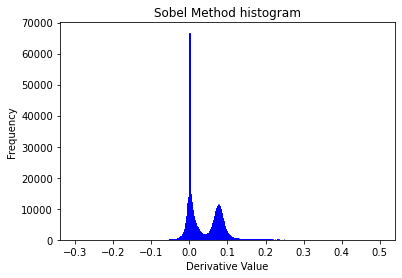

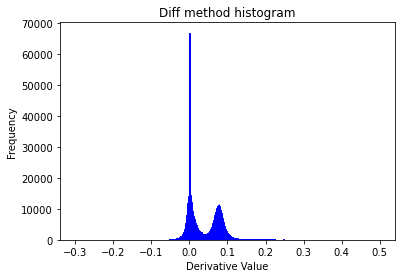

In [140]:


n = 15  # Size of the kernel, as Vipul used in his thesis 5
kernel_k = np.ones(n) / n  # Kernel for averaging

# Gaussian kernel:
n_gaussian = 15  # Size of the kernel
sigma_kernel = 2.0  # Standard deviation which controls the spread

def gaussian_kernel(n_gaussian=n_gaussian, sigma=sigma_kernel): 
    # Create a coordinate vector from -n//2 to n//2
    x = np.arange(-n_gaussian//2 + 1, n_gaussian//2 + 1)

    # Calculate the Gaussian function
    kernel_g = np.exp(-0.5 * (x**2) / sigma**2)

    # Normalize the kernel to ensure the sum of kernel elements equals 1
    kernel_g /= np.sum(kernel_g)

    return kernel_g

kernel_gaussian = gaussian_kernel()

# Old binomial kernel
""" n_binomial = 15

def binomial_kernel(size = n_binomial):
    kernel_b = np.array([1, 1])
    for i in range(size - 2):
        kernel_b = np.convolve(kernel_b, np.array([1, 1]))
    kernel_b = kernel_b.astype(float)
    kernel_b /= np.sum(kernel_b)  # Normalize the kernel
    return kernel_b

kernel_binomial = binomial_kernel() """
from scipy.special import binom

n = 30  # Length of the kernel
kernel_binomial = np.array([binom(n-1, k) for k in range(n)])
kernel_binomial = kernel_binomial / np.sum(kernel_binomial) 

# Velg input Kernel!
# Endre/change/velg
#-------------------------------------------
#input_kernel_lowpass = kernel_k
#kern_bool = True
input_kernel_lowpass = kernel_binomial
kern_bool = False
#-------------------------------------------


# Function to apply low-pass filter to a column
def low_pass_filter(column, K=kernel_k):
    # Apply convolution
    filtered_column = np.convolve(column, K, mode='same')
    return filtered_column

#Endring av input, TELEPORTER hit
#-------------------------------------------
# Endre/change/velg
# Velg disparity bilde her!
#-------------------------------------------
#current_working_disparity, current_working_image 
#første_disparity, første_image 
#nærme_disparity, nærme_image 
#bru_disparity, bru_image 
#båt_disparity, båt_image
#
#dI = bru_disparity
#original_image = bru_image

#dI = båt_disparity
#original_image = båt_image

#dI = første_disparity
#original_image = første_image

#dI = nærme_disparity
#original_image = nærme_image

#dI = kajakk_første_disparity
#original_image = kajakk_første_image

#dI = kajakk_båt_disparity
#original_image = kajakk_båt_image

#dI = kajakk_tett_disparity
#original_image = kajakk_tett_image

#dI = båt_bak_disparity
#original_image = båt_bak_image

#dI = båt_fram_disparity
#original_image = båt_fram_image

dI = badering_første_disparity
original_image = badering_første_image

#dI = badering_mann_disparity
#original_image = badering_mann_image

#dI = badering_midten_disparity
#original_image = badering_midten_image


#-------------------------------------------



interpolate_each_column(dI)

# This is manually doing the above cell
# Apply the low-pass filter to each column
height, width = dI.shape
df = np.zeros_like(dI)  # Low-pass filtered disparity image
for x in range(width):
    df[:, x] = low_pass_filter(dI[:, x], K=input_kernel_lowpass)

#df = cv2.filter2D(dI, -1, input_kernel_lowpass.reshape(-1, 1))  # Reshape for vertical application

# Versjon 1 bruker sobel Kernel til å derivere
# Define the 1D Sobel kernelS
kernel_m = np.array([1, 0, -1])

# Initialize an array to store the vertical derivative image
vertical_derivative = np.zeros_like(df)

# Apply the Sobel kernel to each column
""" for i in range(df.shape[1]):  # Iterate over columns
    vertical_derivative[:, i] = np.convolve(df[:, i], kernel_m, mode='same') """

for i in range(df.shape[1]):  # Iterate over columns
    vertical_derivative[:, i] = np.convolve(df[:, i], kernel_m, mode='same') / 2



# Versjon 2 bruker np.diff 
# Computing the derivative of each column
df_derivative = np.diff(df, axis=0)

# Padding to handle size difference after np.diff
df_derivative = np.pad(df_derivative, ((0, 1), (0, 0)), mode='edge')
#første_df_derivative = np.pad(df_derivative, ((0, 1), (0, 0)), mode='edge') 



# Input should be a disparity image where each column is differentiated
def flatten_and_plot_histogram(df_derivative, plot=True,title="Histogram of Derivative Values", input_bins=2000):
    # Flatten the array of derivatives to a 1D array
    flattened_derivatives = df_derivative.flatten()

    if(plot):
        # Plot the histogram
        plt.figure()
        plt.hist(flattened_derivatives, bins=input_bins, range=(-0.3,0.5), color='blue', edgecolor='blue')
        plt.title(title)
        plt.xlabel('Derivative Value')
        plt.ylabel('Frequency')
        # Show the plot
        plt.show()
    
    return flattened_derivatives
    

# Versjon 1 Sobel
flattened_derivatives_sobel = flatten_and_plot_histogram(vertical_derivative, title="Sobel Method histogram")

# Versjon 2 np.diff
flattened_derivatives_diff = flatten_and_plot_histogram(df_derivative, title="Diff method histogram")

#flattened_derivatives = flattened_derivatives_sobel

flattened_derivatives = flattened_derivatives_diff

## Clustering og klassifisering

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


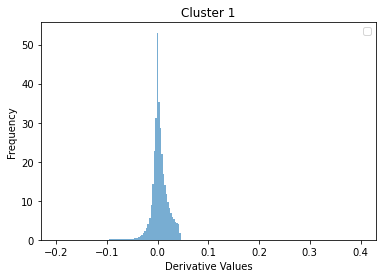

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


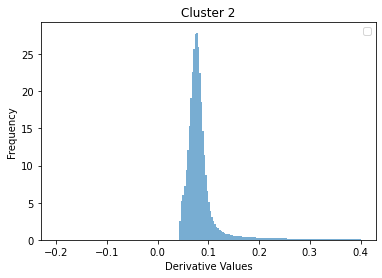

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


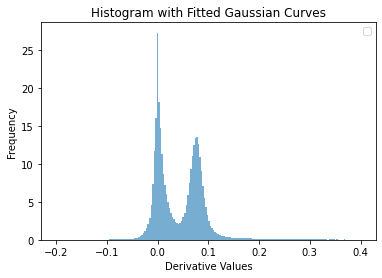

<class 'numpy.ndarray'>
mode:  [0.5]


In [141]:

def gaussian(x, mean, stddev):
    return (1 / (stddev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / stddev) ** 2)

# Gaussian fit function
def fit_gaussian(data):
    mean = np.mean(data)
    stddev = np.std(data)
    return mean, stddev

def clustering(flattened_derivatives, guess1=[0.0], guess2=[0.06], a_mini=-0.3, a_maxi=0.5, clusters=2):
    # Clipping the data to be between -0.3 and 0.5
    clipped_derivatives = np.clip(flattened_derivatives, a_min=a_mini, a_max=a_maxi)

    # Reshape data for KMeans
    clustering_model = clipped_derivatives.reshape(-1, 1)
    
    # Initial guesses for cluster centers (approximated from histogram peaks)
    initial_centers = np.array([guess1, guess2])  # replace peak1, peak2 with your estimates

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=clusters, init=initial_centers, n_init=1)
    kmeans.fit(clustering_model)

    # Get the labels and cluster centers
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    return clustering_model, clipped_derivatives, labels, centers

def clusteringV2(flattened_derivatives, a_mini=-0.3, a_maxi=0.5, clusters=2):
    # Clipping the data to be between -0.3 and 0.5
    clipped_derivatives = np.clip(flattened_derivatives, a_min=a_mini, a_max=a_maxi)

    # Reshape data for KMeans
    clustering_model = clipped_derivatives.reshape(-1, 1)

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=clusters, init='k-means++', n_init=10)
    kmeans.fit(clustering_model)

    # Get the labels and cluster centers
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    return clustering_model, clipped_derivatives, labels, centers

# Sobel versjon
#clustering_model, labels, centers = clustering(flattened_derivatives_sobel, guess1=[0.0], guess2=[0.15])
# Diff
clustering_model, clipped_derivatives, labels, centers = clusteringV2(flattened_derivatives_diff)

# Relocation the mean to match the mode for a more accurate distribution

cluster1 = clustering_model[labels == 0]
cluster2 = clustering_model[labels == 1]

plt.figure()
plt.hist(cluster1, bins=200, range=(-0.2, 0.4), density=True, alpha=0.6)
plt.xlabel('Derivative Values')
plt.ylabel('Frequency')
plt.title('Cluster 1')
plt.legend()
plt.show()

# Plot histogram 
plt.figure()
plt.hist(cluster2, bins=200, range=(-0.2, 0.4), density=True, alpha=0.6)
plt.xlabel('Derivative Values')
plt.ylabel('Frequency')
plt.title('Cluster 2')
plt.legend()
plt.show()

plt.figure()
plt.hist(clustering_model, bins=200, range=(-0.2, 0.4), density=True, alpha=0.6)
plt.xlabel('Derivative Values')
plt.ylabel('Frequency')
plt.title('Histogram with Fitted Gaussian Curves')
plt.legend()
plt.show()

mode_result = stats.mode(cluster2)
print(type(mode_result.mode))

print("mode: ", stats.mode(cluster2).mode[0])



Mean 1:  -0.00044354008
Stddev 1:  0.038831323
Mean 2:  0.0889462
Stddev 2:  0.054072045
Mode 1:  [0.]
Mode 2:  [0.5]


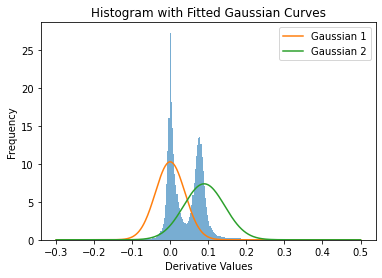

In [142]:

# Fit Gaussian to each cluster
mean1, stddev1 = fit_gaussian(cluster1)
mean2, stddev2 = fit_gaussian(cluster2)
#stddev1, stddev2 = 0.02, 0.02
print("Mean 1: ",mean1)
print("Stddev 1: ",stddev1)
print("Mean 2: ",mean2)
print("Stddev 2: ",stddev2)
print("Mode 1: ", stats.mode(cluster1).mode[0])
print("Mode 2: ", stats.mode(cluster2).mode[0])

if(kern_bool):
    mean1 = stats.mode(cluster1).mode[0]
    mean2 = stats.mode(cluster2).mode[0]


# Determine which mean is closer to 0 and assign labels
if abs(mean1) < abs(mean2):
    red_mean, green_mean = mean1, mean2
    red_stddev, green_stddev = stddev1, stddev2
    red_label, green_label = 'Cluster 1 (Red)', 'Cluster 2 (Green)'
else:
    red_mean, green_mean = mean2, mean1
    red_stddev, green_stddev = stddev2, stddev1
    red_label, green_label = 'Cluster 2 (Red)', 'Cluster 1 (Green)'

# Below are the upper and lower bounds
# Assuming you have mean1, stddev1, mean2, stddev2 from the Gaussian fits
k = 1 # Adjust this constant as needed

""" shift_amount = 0.02  # Adjust this value to shift the curve to the left
# Adjust mean2 for Gaussian Curve 2
adjusted_mean2 = mean2 - shift_amount
mean2 = mean2 - shift_amount 
#gaussian_curve2Adjust = gaussian(x_values, adjusted_mean2, stddev2)
"""

# Calculate range limits for each Gaussian curve
dL1 = mean1 - k * stddev1
dU1 = mean1 + k * stddev1
dL2 = mean2 - k * stddev2
dU2 = mean2 + k * stddev2

red_dL = red_mean - k * red_stddev
red_dU = red_mean + k * red_stddev
green_dL = green_mean - k * green_stddev
green_dU = green_mean + k * green_stddev


# Create a range of x values
x_values = np.linspace(-0.3, 0.5, 400)



# Gaussian curves
gaussian_curve1 = gaussian(x_values, mean1, stddev1)
gaussian_curve2 = gaussian(x_values, mean2, stddev2)


# Plot histogram and Gaussian curves
plt.figure()
plt.hist(clipped_derivatives, bins=200, range=(-0.2, 0.4), density=True, alpha=0.6)
plt.plot(x_values, gaussian_curve1, label='Gaussian 1')
plt.plot(x_values, gaussian_curve2, label='Gaussian 2')
plt.xlabel('Derivative Values')
plt.ylabel('Frequency')
plt.title('Histogram with Fitted Gaussian Curves')
plt.legend()
plt.show()

includes undecided
[[ 0.7484703   0.7478583   0.74936867 ...  0.4527148   0.47519398
   0.49820554]
 [ 0.66371655  0.6628938   0.66361    ...  0.36253834  0.37595677
   0.39073563]
 [ 0.5197487   0.5186918   0.51836205 ...  0.23475027  0.23727393
   0.24198627]
 ...
 [-4.96566    -4.9609604  -4.956547   ... -4.7862663  -4.787426
  -4.7898064 ]
 [-6.532406   -6.5266266  -6.5202217  ... -6.2768097  -6.276989
  -6.2789803 ]
 [-6.532406   -6.5266266  -6.5202217  ... -6.2768097  -6.276989
  -6.2789803 ]]
[['unknown' 'unknown' 'unknown' ... 'unknown' 'unknown' 'unknown']
 ['unknown' 'unknown' 'unknown' ... 'unknown' 'unknown' 'unknown']
 ['unknown' 'unknown' 'unknown' ... 'unknown' 'unknown' 'unknown']
 ...
 ['unknown' 'unknown' 'unknown' ... 'unknown' 'unknown' 'unknown']
 ['unknown' 'unknown' 'unknown' ... 'unknown' 'unknown' 'unknown']
 ['unknown' 'unknown' 'unknown' ... 'unknown' 'unknown' 'unknown']]


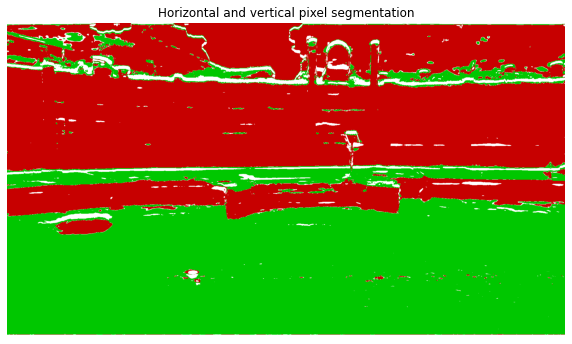

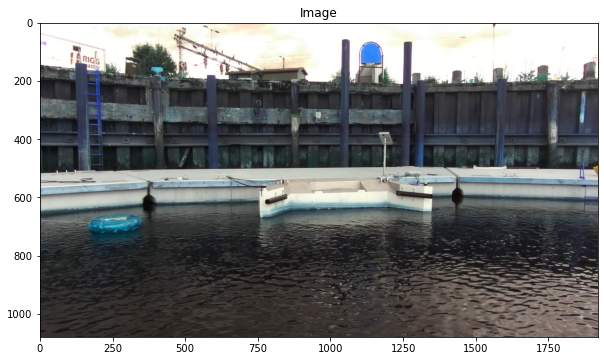

In [143]:
# And dL1, dU1, dL2, dU2 are the range limits for the two Gaussians
classification_map = np.empty(df_derivative.shape, dtype=object)

include_undecided_label = True

if include_undecided_label:
    print("includes undecided")
    for i in range(df_derivative.shape[0]):  # Rows
        for j in range(df_derivative.shape[1]):  # Columns
            derivative_value = df_derivative[i, j]

            # Check if the derivative value falls into the range of either Gaussian
            if (red_dL <= derivative_value <= red_dU) and (green_dL <= derivative_value <= green_dU):
                classification = 'undecided'
            elif red_dL <= derivative_value <= red_dU:
                classification = 'upright'  # Red cluster
            elif green_dL <= derivative_value <= green_dU:
                classification = 'horizontal'  # Green cluster
            else:
                classification = 'unknown'

            classification_map[i, j] = classification
else:
    print("Undecided and unknown is the same")
    for i in range(df_derivative.shape[0]):  # Rows
        for j in range(df_derivative.shape[1]):  # Columns
            derivative_value = df_derivative[i, j]

            # Check if the derivative value falls into the range of either Gaussian
            if (red_dL <= derivative_value <= red_dU) and (green_dL <= derivative_value <= green_dU):
                classification = 'unknown'
            elif red_dL <= derivative_value <= red_dU:
                classification = 'upright'  # Red cluster
            elif green_dL <= derivative_value <= green_dU:
                classification = 'horizontal'  # Green cluster
            else:
                classification = 'unknown'

            classification_map[i, j] = classification

print(df_derivative)
print(classification_map)

""" # Dark color definitions with brightness < 128/256
# Brightness = 0.18
Navy_Blue = [0, 0, 128/256]  # Brightness = 0.17
Dark_Slate_Gray = [47/256, 79/256, 79/256]  # Brightness = 0.32
Dark_Cyan = [0, 139/256, 139/256]  # Brightness = 0.18
Dark_Goldenrod = [184/256, 134/256, 11/256]  # Adjusted to be darker
White= [1,1,1]

# Revised dark, distinct color definitions
Dark_Red = [139/256, 0, 0]  # Rich, dark red
Dark_Slate_Gray = [47/256, 79/256, 79/256]
Sienna = [160/256, 82/256, 45/256]  # Earthy, medium dark
Dark_Orange = [255/256, 140/256, 0]  # Vibrant, but darkened
Saddle_Brown = [139/256, 69/256, 19/256] 
Pure_Red =[200/256,0,0]

# Horizontal color definitions
Indigo = [75/256, 0, 130/256]  # Deep indigo blue
Teal = [0, 128/256, 128/256]  # Rich teal blue
Forest_Green = [34/256, 139/256, 34/256]  # Deep forest green
Dark_Olive_Green = [85/256, 107/256, 47/256]  # Muted, darker green
Midnight_Blue = [25/256, 25/256, 112/256] 
Dark_Green = [0, 100/256, 0]  
Pure_Green = [0,200/256,0]
Pure_Blue = [0,0,200/256]


# Dark color definitions with brightness < 128/256
Dark_Red = [139/256, 0, 0]  # Rich, dark red
Dark_Blue = [0, 0, 128/256]  # Deep blue, similar to navy
Dark_Green = [0, 100/256, 0]  # Deep green
Dark_Yellow = [128/256, 128/256, 0]  # Muted yellow, darkened
Dark_Purple = [75/256, 0, 130/256]  # Similar to indigo, dark purple
Dark_Orange = [255/256, 140/256, 0]  # Vibrant, but darkened to fit within limits
Dark_Cyan = [0, 139/256, 139/256]  # Rich cyan, darkened
Dark_Magenta = [139/256, 0, 139/256]  # Deep magenta
Charcoal_Gray = [50/256, 50/256, 50/256]  # Dark gray, akin to charcoal
Dark_Lime = [50/256, 205/256, 50/256]  # A darker shade of lime green
Dark_Pink = [255/256, 20/256, 147/256]  # Deep pink, darkened
Dark_Olive = [85/256, 107/256, 47/256]  # Muted, darker olive green
Dark_Turquoise = [0, 206/256, 209/256]  # Deep turquoise
Dark_Brown = [165/256, 42/256, 42/256]  # A rich, dark brown
 """


# Dark color definitions with brightness < 128/256
Dark_Red = [100/256, 0, 0]  # Rich, dark red
Dark_Blue = [0, 0, 100/256]  # Deep blue, similar to navy
Dark_Green = [0, 100/256, 0]  # Deep green
Bright_Red = [200/256, 0, 0]  # Bright red
Bright_Green = [0, 200/256, 0]  # Bright green
Bright_Blue = [0, 0, 200/256]  # Bright blue
Dark_Yellow = [128/256, 128/256, 0]  # Muted yellow, darkened
Dark_Purple = [75/256, 0, 130/256]  # Similar to indigo, dark purple
Dark_Orange = [255/256, 140/256, 0]  # Vibrant, but darkened to fit within limits
Dark_Cyan = [0, 139/256, 139/256]  # Rich cyan, darkened
Dark_Magenta = [139/256, 0, 139/256]  # Deep magenta
Charcoal_Gray = [50/256, 50/256, 50/256]  # Dark gray, akin to charcoal
Dark_Lime = [50/256, 205/256, 50/256]  # A darker shade of lime green
Dark_Pink = [255/256, 20/256, 147/256]  # Deep pink, darkened
Dark_Olive = [85/256, 107/256, 47/256]  # Muted, darker olive green
Dark_Turquoise = [0, 206/256, 209/256]  # Deep turquoise
Dark_Brown = [165/256, 42/256, 42/256]  # A rich, dark brown
Dark_Goldenrod = [184/256, 134/256, 11/256] # Dark goldenrod
White = [1, 1, 1]  # White

colorScheme = {
    'horizontal1': Bright_Green,
    'horizontal2': Bright_Blue,
    'horizontal3': Dark_Green,
    'horizontal4': Dark_Brown,
    'horizontal5': Dark_Blue,
    'horizontal6': Charcoal_Gray,  # Custom darker teal
    'horizontal7': Dark_Lime,  # Custom dark leaf green
    'vertical1': Bright_Red,
    'vertical2': Dark_Magenta,
    'vertical3': Dark_Yellow,
    'vertical4': Dark_Red,
    'vertical5': Dark_Pink, 
    'vertical6': Dark_Orange,  # Dark Orchid
    'vertical7': Dark_Goldenrod,  # Dark Goldenrod
    'unknown': White,  # White
    'undecided': White,  # White
    'upright': Bright_Red,
    'horizontal': Bright_Green
}


def assign_colours_and_plot(classification_map, colors=colorScheme, plot=True, title="Pixel-wise Disparity Map Classification"):
    # Create an empty array for the color-coded image
    color_coded_image = np.zeros((*classification_map.shape, 3))

    # Assign colors
    for classification, color in colors.items():
        mask = classification_map == classification
        color_coded_image[mask] = color

    if(plot):
        plt.figure(figsize=(10, 6))
        plt.imshow(color_coded_image)
        plt.title(title)
        plt.axis('off')  # Hide the axes
        plt.show()



# Nærme
#display_disp_image(nærme_image)
# Båt
#display_disp_image(båt_test_bilde)
assign_colours_and_plot(classification_map, title="Horizontal and vertical pixel segmentation")
display_disp_image(original_image)


## Vertikal overflate reklassifisering

In [144]:
surface_splitting_disparity_image = dI

vertCount = 0
horCount = 0
noneCount = 0

# Verticals
vertical_Derivative_List = []
vertical_Disp_List = []
vertical_Obj_List = []


#Horizonals
horizontal_Derivative_List = []
horizontal_Disp_List = []
horizontal_Obj_List = []

divided_horizontal_obj_list = []


for i in range(classification_map.shape[0]):  # Rows

    single_col_obj_list = []
    for j in range(classification_map.shape[1]):  # Columns

        current_local_value = classification_map[i, j]

        if(current_local_value == 'upright'):
            vertCount += 1
            vertical_Derivative_List.append(df_derivative[i,j])
            appendObjectVert = [surface_splitting_disparity_image[i, j], i, j, 'vertical']
            vertical_Disp_List.append(surface_splitting_disparity_image[i,j])
            vertical_Obj_List.append(appendObjectVert)
        
        
        
        elif(current_local_value == 'horizontal'):
            horCount += 1
            der_val = df_derivative[i, j]
            horizontal_Derivative_List.append(der_val)
            # Object = [Disparity value, vertical derivative value, i coordinate, j coordinate, label]
            appendObjectHor = [surface_splitting_disparity_image[i, j], der_val, i, j, 'horizontal']
            horizontal_Disp_List.append(surface_splitting_disparity_image[i,j])
            horizontal_Obj_List.append(appendObjectHor)
            single_col_obj_list.append(appendObjectHor)

        else:
            noneCount+=1
    divided_horizontal_obj_list.append(single_col_obj_list)

print("verticals: ", vertCount)
print("Horizontals: ", horCount)
print("Unknown: ", noneCount)
print("[Disparity Value, Derivative Value, V index, U index, Label]")
print(horizontal_Obj_List[202])

verticals:  998335
Horizontals:  969796
Unknown:  105469
[Disparity Value, Derivative Value, V index, U index, Label]
[1.8945312, 0.13498104, 3, 1056, 'horizontal']


In [145]:
# Assuming vertical_Disp_List is a list of disparity values
vertical_Disp_List = np.array(vertical_Disp_List)  # Convert list to NumPy array for efficient operations

# Adding higher percentiles (97%, 98%, 99%)
p97 = np.percentile(vertical_Disp_List, 97)
p3 = np.percentile(vertical_Disp_List, 3)
filtered_data_97 = vertical_Disp_List[(vertical_Disp_List >= p3) & (vertical_Disp_List <= p97)]

p98 = np.percentile(vertical_Disp_List, 98)
p2 = np.percentile(vertical_Disp_List, 2)
filtered_data_98 = vertical_Disp_List[(vertical_Disp_List >= p2) & (vertical_Disp_List <= p98)]
filtered_data_2 = vertical_Disp_List[(vertical_Disp_List < p2) | (vertical_Disp_List > p98)]

p99 = np.percentile(vertical_Disp_List, 99)
p1 = np.percentile(vertical_Disp_List, 1)
filtered_data_99 = vertical_Disp_List[(vertical_Disp_List >= p1) & (vertical_Disp_List <= p99)]

len_97 = len(filtered_data_97)
len_98 = len(filtered_data_98)
len_99 = len(filtered_data_99)


print("Length of data capturing 97%: ", len_97)
print("Length of data capturing 98%: ", len_98)
print("Length of data capturing 99%: ", len_99)

min_97 = min(filtered_data_97)
max_97 = max(filtered_data_97)

min_98 = min(filtered_data_98)
max_98 = max(filtered_data_98)

min_99 = min(filtered_data_99)
max_99 = max(filtered_data_99)

min_2 = min(filtered_data_2)
max_2 = max(filtered_data_2)

print("Min: ", min_97, " and max: ", max_97, " for values within 97%")
print("Min: ", min_98, " and max: ", max_98, " for values within 98%")
print("Min ", min_99, " and max: ", max_99, " for values within 99%")

print("")
print("Min: ", min_2, " and max: ", max_2, " for values outside 98%")

Length of data capturing 97%:  968414
Length of data capturing 98%:  978445
Length of data capturing 99%:  988353
Min:  0.0  and max:  18.628906  for values within 97%
Min:  0.0  and max:  19.195312  for values within 98%
Min  0.0  and max:  22.613281  for values within 99%

Min:  19.199219  and max:  51.14453  for values outside 98%


### Number of clusters analyse

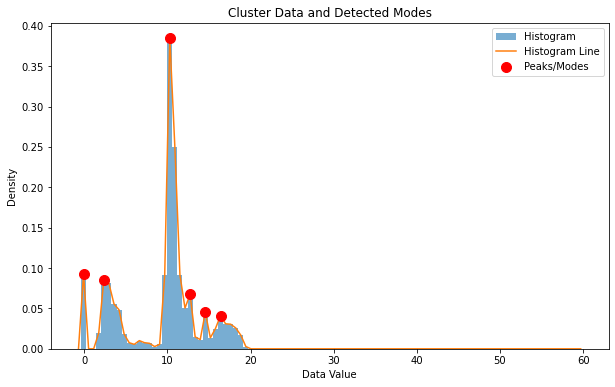

Detected modes at: [-0.08499999  2.355      10.285      12.725      14.555      16.385     ]


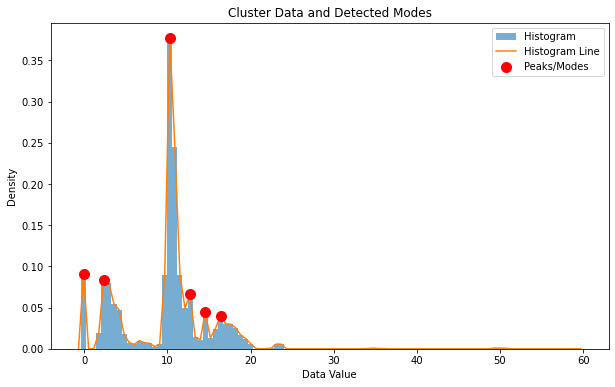

Detected modes at: [-0.08499999  2.355      10.285      12.725      14.555      16.385     ]


In [146]:
from scipy.signal import find_peaks
auto_range=(-1,60)
def plot_histogram_with_peaks(data, bins, min_prominence=0.01, min_distance=1, auto_range=auto_range):

    # Ensure data is cleaned
    data = np.array(data)
    data = data[np.isfinite(data)]


    hist, bin_edges = np.histogram(data,range=auto_range, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Get bin centers for plotting

    # Find peaks with adjusted parameters
    peaks, properties = find_peaks(hist, prominence=min_prominence, distance=min_distance)

    # Plotting the histogram and peaks
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=bins,  range=auto_range, alpha=0.6, label='Histogram', density=True)
    plt.plot(bin_centers, hist, label='Histogram Line')
    plt.scatter(bin_centers[peaks], hist[peaks],color='red', s=100, zorder=5, label='Peaks/Modes')
    plt.title('Cluster Data and Detected Modes')
    plt.xlabel('Data Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    # Print peak bin centers
    peak_values = bin_centers[peaks]
    print("Detected modes at:", peak_values)
    return peak_values

# Call the function with parameters adjusted based on your description
detected_modes = plot_histogram_with_peaks(filtered_data_98, bins=100, min_prominence=0.01, min_distance=1)
detected_modes = plot_histogram_with_peaks(vertical_Disp_List, bins=100, min_prominence=0.01, min_distance=1)




Number og clusters:  6


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


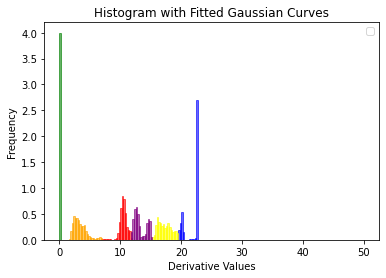

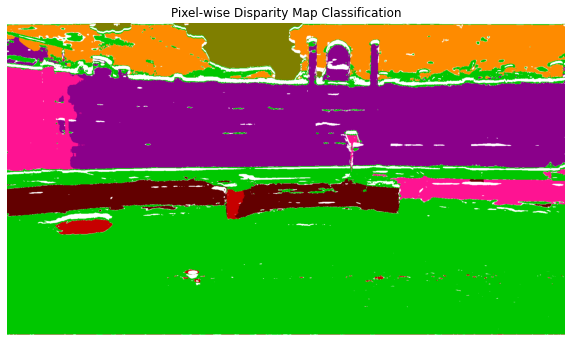

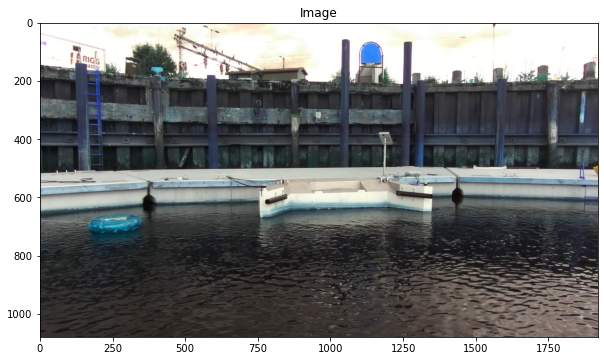

In [147]:
def clusteringVerticalSurfaces(flattened_derivatives, a_mini=-0.3, a_maxi=50, clusters=4):
    # Clipping the data to be between -0.3 and 0.5
    clipped_derivatives = np.clip(flattened_derivatives, a_min=a_mini, a_max=a_maxi)

    # Reshape data for KMeans
    clustering_model = clipped_derivatives.reshape(-1, 1)    

    #kmeans = KMeans(n_clusters=clusters, init=initial_centers, n_init=1)
    kmeans = KMeans(n_clusters=clusters, init='k-means++', n_init=10)
    kmeans.fit(clustering_model)

    # Get the labels and cluster centers
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    return clustering_model, clipped_derivatives, labels, centers

num_clusters = len(detected_modes)

#model_choice = "Standard"
#model_choice= "Simple_98"
#model_choice = "Advanced_98"
model_choice = "Simple_99"
#model_choice = "Advanced_99"

# Standard model
if(model_choice == "Standard"):
    clustering_model, clipped_derivatives, labels, centers = clusteringVerticalSurfaces(vertical_Disp_List, clusters=num_clusters)

# 98th percentile model
if(model_choice == "Simple_98"):
    clustering_model, clipped_derivatives, labels, centers = clusteringVerticalSurfaces(vertical_Disp_List, clusters=num_clusters, a_mini=min_98, a_maxi=max_98)

# 98th percentile + Unknown labelings
if(model_choice =="Advanced_98"):
    clustering_model, clipped_derivatives, labels, centers = clusteringVerticalSurfaces(filtered_data_98, clusters=num_clusters, a_mini=min_98, a_maxi=max_98)

if(model_choice =="Simple_99"):
    clustering_model, clipped_derivatives, labels, centers = clusteringVerticalSurfaces(vertical_Disp_List, clusters=num_clusters, a_mini=min_99, a_maxi=max_99)

if(model_choice =="Advanced_99"):
    clustering_model, clipped_derivatives, labels, centers = clusteringVerticalSurfaces(filtered_data_99, clusters=num_clusters, a_mini=min_99, a_maxi=max_99)




# Separate the data into two clusters
print("Number og clusters: ", num_clusters)
if(num_clusters>= 1):
    cluster1 = clustering_model[labels == 0]
if(num_clusters>= 2):
    cluster2 = clustering_model[labels == 1]
if(num_clusters >= 3):
    cluster3 = clustering_model[labels == 2]
if(num_clusters >= 4):
    cluster4 = clustering_model[labels == 3]
if(num_clusters >= 5):
    cluster5 = clustering_model[labels == 4]
if(num_clusters >= 6):
    cluster6 = clustering_model[labels == 5]
if(num_clusters >= 7):
    cluster7 = clustering_model[labels == 6]
if(num_clusters >= 8):
    cluster8 = clustering_model[labels == 7]      


# Plot histogram and Gaussian curves
plt.figure()
if(num_clusters>= 1):
    plt.hist(cluster1, bins=200, range=(0, 50), density=True, alpha=0.6, color='blue', edgecolor='blue')
if(num_clusters>= 2):
    plt.hist(cluster2, bins=200, range=(0, 50), density=True, alpha=0.6, color='red', edgecolor='red')
if(num_clusters>= 3):
    plt.hist(cluster3, bins=200, range=(0, 50), density=True, alpha=0.6, color='green', edgecolor='green')
if(num_clusters>= 4):
    plt.hist(cluster4, bins=200, range=(0, 50), density=True, alpha=0.6, color='yellow', edgecolor='yellow')
if(num_clusters>= 5):
    plt.hist(cluster5, bins=200, range=(0, 50), density=True, alpha=0.6, color='purple', edgecolor='purple')
if(num_clusters>= 6):
    plt.hist(cluster6, bins=200, range=(0, 50), density=True, alpha=0.6, color='orange', edgecolor='orange')
if(num_clusters>= 7):
    plt.hist(cluster7, bins=200, range=(0, 50), density=True, alpha=0.6, color='black', edgecolor='black')
if(num_clusters>= 8):
    plt.hist(cluster8, bins=200, range=(0, 50), density=True, alpha=0.6, color='pink', edgecolor='pink')
#plt.plot(x_values, gaussian_curve1, label='Gaussian 1')
#plt.plot(x_values, gaussian_curve2, label='Gaussian 2')
plt.xlabel('Derivative Values')
plt.ylabel('Frequency')
plt.title('Histogram with Fitted Gaussian Curves')
plt.legend()
plt.show()

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Create classmap
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------
length_labels = len(labels)
for i, obj in enumerate(vertical_Obj_List):

    if(i>=length_labels):
        obj[3] = "unknown"
    elif(labels[i] == 0):
        obj[3] = "vertical1"
    elif(labels[i] == 1):
        obj[3] = "vertical2"
    elif(labels[i] == 2):
        obj[3] = "vertical3"
    elif(labels[i] == 3):
        obj[3] = "vertical4"
    elif(labels[i]==4):
        obj[3] = "vertical5"
    elif(labels[i]==5):
        obj[3] = "vertical6"
    elif(labels[i]==6):
        obj[3] = "vertical7"
    else:
        obj[3] = "unknown"

""" if(model_choice =="Advanced_98"):
    for i in range(filtered_data_2):
        # Iterate over each value in filtered_data_2
        for value in filtered_data_2:
            # Find indices where the first element of each sublist in vertical_obj_list equals the current value
            indices = [i for i, sublist in enumerate(vertical_Obj_List) if sublist[0] == value]

            # Update the label for all matching sublists
            for idx in indices:
                vertical_Obj_List[idx][-1] = 'unknown'
 """

new_class_map = np.copy(classification_map)

for i, obj in enumerate(vertical_Obj_List):
    i = obj[1]
    j= obj[2]
    new_class_map[i,j] = obj[3]


""" # Dark color definitions with brightness < 128/256
# Brightness = 0.18
Navy_Blue = [0, 0, 128/256]  # Brightness = 0.17
Dark_Slate_Gray = [47/256, 79/256, 79/256]  # Brightness = 0.32
Dark_Cyan = [0, 139/256, 139/256]  # Brightness = 0.18
Dark_Goldenrod = [184/256, 134/256, 11/256]  # Adjusted to be darker
White= [1,1,1]

# Revised dark, distinct color definitions
Dark_Red = [139/256, 0, 0]  # Rich, dark red
Dark_Slate_Gray = [47/256, 79/256, 79/256]
Sienna = [160/256, 82/256, 45/256]  # Earthy, medium dark
Dark_Orange = [255/256, 140/256, 0]  # Vibrant, but darkened
Saddle_Brown = [139/256, 69/256, 19/256] 
Pure_Red =[200/256,0,0]

# Horizontal color definitions
Indigo = [75/256, 0, 130/256]  # Deep indigo blue
Teal = [0, 128/256, 128/256]  # Rich teal blue
Forest_Green = [34/256, 139/256, 34/256]  # Deep forest green
Dark_Olive_Green = [85/256, 107/256, 47/256]  # Muted, darker green
Midnight_Blue = [25/256, 25/256, 112/256] 
Dark_Green = [0, 100/256, 0]  
Pure_Green = [0,200/256,0]
Pure_Blue = [0,0,200/256]


# Updated color scheme for classification ensuring maximum distinction
colorScheme = {
    'horizontal1': Navy_Blue,
    'horizontal2': Teal,
    'horizontal3': Pure_Green,
    'horizontal4': Indigo,
    'horizontal5': Dark_Olive_Green,
    'horizontal6': Pure_Green,  # Custom darker teal
    'horizontal7': Dark_Green,  # Custom dark leaf green
    'vertical1': Dark_Red,
    'vertical2': Pure_Red,
    'vertical3': Sienna,
    'vertical4': Dark_Orange,
    'vertical5': Dark_Slate_Gray,  # Custom burnt orange
    'vertical6': Saddle_Brown,  # Custom dark brown
    'vertical7': Dark_Goldenrod,  # Custom dark red
    'unknown': White,  # White
    'undecided': White,  # White
    'upright': Pure_Red,
    'horizontal': Pure_Green
}"""


# Create an empty array for the color-coded image
color_coded_image = np.zeros((*new_class_map.shape, 3))
#print(color_coded_image)


color_coded_image = np.zeros((*new_class_map.shape, 3))

# Assign colors based on the classification in new_class_map
for label, color in colorScheme.items():
    # Find indices where the current label is present in new_class_map
    indices = np.where(new_class_map == label)
    # Assign the corresponding color to these indices in the color-coded image
    color_coded_image[indices] = color

#print(color_coded_image)
plt.figure(figsize=(10, 6))
plt.imshow(color_coded_image)
plt.title('Pixel-wise Disparity Map Classification')
plt.axis('off')  # Hide the axes
plt.show() 
display_disp_image( original_image)

### Disparity profil analyse

[ 2.1992188  2.2304688  2.2617188 ... 50.703125  50.816406  50.867188 ]
[ 0.33419716  0.2994318   0.23837864 ... -4.8552437  -6.376911
 -6.376911  ]
['unknown' 'unknown' 'unknown' ... 'unknown' 'unknown' 'unknown']
501
IndexListHorCol:  [4, 5, 6, 17, 18, 19, 20, 50, 51, 52, 53, 54, 55, 129, 130, 131, 132, 133, 135, 136, 137, 138, 179, 180, 181, 194, 195, 196, 197, 496, 497, 498, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 625, 626, 627, 628, 629, 630, 631, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725

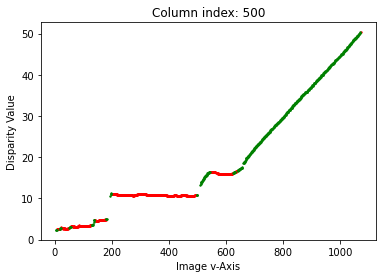

In [148]:
# Endre/change/velg
# Velg column index here
column_index = 500

#Total rows (v) up = 1080
#Total columns (u) right = 1920

# Endre/change/velg
# Velg column data here
column_data = surface_splitting_disparity_image[:, column_index]
y_values = range(len(column_data))



print(surface_splitting_disparity_image[:, column_index])
print(df_derivative[:, column_index])
print(classification_map[:, column_index])

count = 0
#horizontal_column_disparity_list = []



def single_column_list_generator(column_index=column_index, only_return_hor_col=False):

    horizontal_column_derivative_list = []
    horizontal_column_object_list = []
    vertical_column_derivative_list = []
    vertical_column_object_list = []
    for i, val in enumerate(classification_map[:, column_index]):
        #print(val)
        
        if(val == 'horizontal'):
            der = df_derivative[i, column_index]
            disp = surface_splitting_disparity_image[i, column_index]

            appendObjColHor = [der, disp, i, column_index, val]
            horizontal_column_derivative_list.append(der)
            horizontal_column_object_list.append(appendObjColHor)

        #if(val == 'vertical1' or val == 'vertical2' or val == 'vertical3' or val == 'vertical4'):
        if(val == 'upright'):
            der = df_derivative[i, column_index]
            disp = surface_splitting_disparity_image[i, column_index]

            appendObjColVert = [der, disp, i, column_index, val]
            vertical_column_derivative_list.append(der)
            vertical_column_object_list.append(appendObjColVert)
    if(only_return_hor_col):
        return horizontal_column_object_list
    return horizontal_column_derivative_list, horizontal_column_object_list, vertical_column_derivative_list, vertical_column_object_list

horizontal_column_derivative_list, horizontal_column_object_list, vertical_column_derivative_list, vertical_column_object_list = single_column_list_generator()

def generate_index_list(column_object_list=horizontal_column_object_list):
    indexListColumn = []
    for i in range(len(column_object_list)):
        ind = column_object_list[i][2]
        indexListColumn.append(ind)
    return indexListColumn




# Index list horCOl
print(len(horizontal_column_object_list))
indexListHorCol = []
for i in range(len(horizontal_column_object_list)):
    ind = horizontal_column_object_list[i][2]
    indexListHorCol.append(ind)
    #print("Index ", ind)
print("IndexListHorCol: ",indexListHorCol)


# Index list vertCol
print(len(vertical_column_object_list))
indexListVertCol = []
for i in range(len(vertical_column_object_list)):
    ind = vertical_column_object_list[i][2]
    indexListVertCol.append(ind)
    #print("Index ", ind)
print("IndexListVertCol: ",indexListVertCol)




plt.figure()
#plt.plot(y_values, column_data)

highlighted_horizontal_y_values = [y_values[i] for i in indexListHorCol]
highlighted_horizontal_column_data = [column_data[i] for i in indexListHorCol]

highlighted_vertical_y_values = [y_values[i] for i in indexListVertCol]
highlighted_vertical_column_data = [column_data[i] for i in indexListVertCol]



# Plotting highlighted points on top with a different color
plt.scatter(highlighted_vertical_y_values, highlighted_vertical_column_data, color='red', s=2, zorder=1, label='Highlighted Points')
plt.scatter(highlighted_horizontal_y_values, highlighted_horizontal_column_data, color='green', s=2, zorder=1, label='Highlighted Points')

title_for_plot= 'Column index: ' + str(column_index)
plt.gca()
plt.ylabel('Disparity Value')
plt.xlabel('Image v-Axis')
plt.title(title_for_plot)
plt.show()

import matplotlib.colors as mcolors

def generate_dark_colors(n):
    # Define the saturation and value for dark colors
    saturation = 1.0  # full saturation for vivid colors
    value = 0.6  # dark enough to ensure good contrast on a white background
    
    # Generate colors
    colors = []
    for i in range(n):
        hue = i / n  # Evenly space hues around the color wheel
        rgb = mcolors.hsv_to_rgb((hue, saturation, value))
        colors.append(rgb)
    
    return colors

# Example usage: generate 10 dark, distinct colors
num_colors = 10
dark_colors = generate_dark_colors(num_colors)


## Horisontal overflate reklassifisering

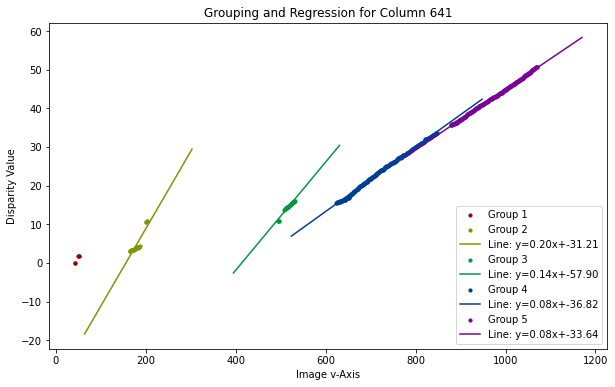

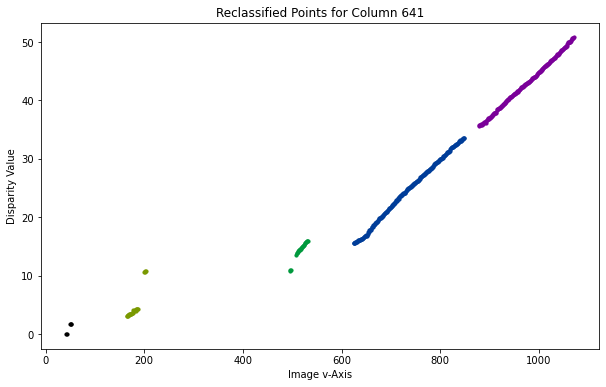

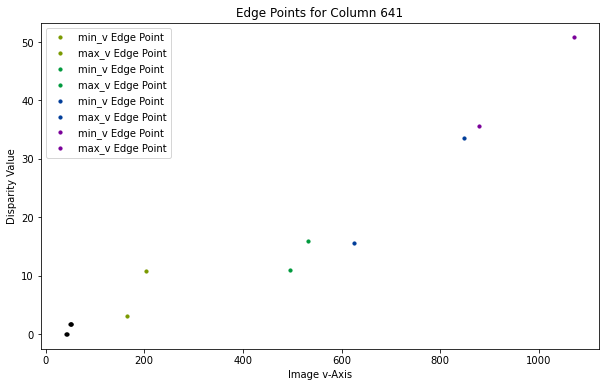

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


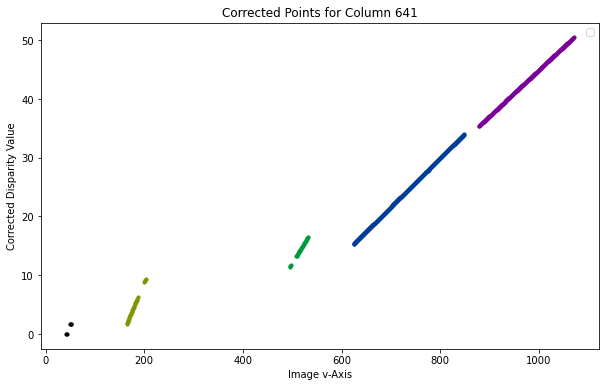

index:  0
Group: [[641, 164, 1.6199218267925524, 'horizontal4'], [641, 165, 1.8201070559000847, 'horizontal4'], [641, 166, 2.020292285007617, 'horizontal4'], [641, 167, 2.2204775141151494, 'horizontal4'], [641, 168, 2.4206627432226817, 'horizontal4'], [641, 169, 2.620847972330207, 'horizontal4'], [641, 170, 2.8210332014377393, 'horizontal4'], [641, 171, 3.0212184305452716, 'horizontal4'], [641, 172, 3.221403659652804, 'horizontal4'], [641, 173, 3.4215888887603363, 'horizontal4'], [641, 174, 3.6217741178678686, 'horizontal4'], [641, 175, 3.821959346975401, 'horizontal4'], [641, 176, 4.022144576082933, 'horizontal4'], [641, 177, 4.222329805190466, 'horizontal4'], [641, 178, 4.422515034297998, 'horizontal4'], [641, 179, 4.62270026340553, 'horizontal4'], [641, 180, 4.822885492513063, 'horizontal4'], [641, 181, 5.023070721620595, 'horizontal4'], [641, 182, 5.22325595072812, 'horizontal4'], [641, 183, 5.4234411798356525, 'horizontal4'], [641, 184, 5.623626408943185, 'horizontal4'], [641, 185

In [149]:
def group_indices(indices, limit=10):
    if not indices:
        return []
    sorted_indices = sorted(indices)
    groups = [[sorted_indices[0]]]
    for index in sorted_indices[1:]:
        if index - groups[-1][-1] <= limit:
            groups[-1].append(index)
        else:
            groups.append([index])
    
    return groups

def perform_linear_regression(groups, y_values, column_data, return_boundaries=True):
    line_equations = []
    edge_boundaries = []  # List to store edge boundaries for each group
    min_size = 10
    for group in groups:
        if len(group) >= min_size:
            group_y_values = np.array([y_values[idx] for idx in group])
            group_column_data = np.array([column_data[idx] for idx in group])
            A = np.vstack([group_y_values, np.ones(len(group_y_values))]).T
            m, c = np.linalg.lstsq(A, group_column_data, rcond=None)[0]
            line_equations.append((m, c))
            # Store the min and max v-values for the group
            edge_boundaries.append((min(group_y_values), max(group_y_values)))
        else:
            line_equations.append(None)
            edge_boundaries.append(None)
    if return_boundaries:
        return line_equations, edge_boundaries
    return line_equations

def vertical_distance_to_line(u_value, disparity, line_params):
    """
    Calculate the vertical distance from a point to a line given by slope and intercept.
    
    Parameters:
    point (tuple): A tuple (x, y) representing the coordinates of the point.
    line_params (tuple): A tuple (m, b) where m is the slope and b is the intercept of the line.

    Returns:
    float: The vertical distance from the point to the line.
    """
    x = u_value 
    y = disparity
    slope, intercept = line_params
    # Calculate the y-value on the line at x
    line_y = slope * x + intercept
    # Calculate the vertical distance
    return abs(y - line_y)


def reclassify_points_and_identify_edges(indexList, column_data, line_equations, edge_boundaries, column_index):
    reclassified_points = []
    edge_points = {}
    corrected_points = []  # New list to store corrected points
    unknown_points = []

    for idx, v_value in enumerate(indexList):
        u_value = column_index
        disparity = column_data[v_value]
        

        """ # Function to calculate distance to line
        def distance_to_line(line):
            m, c = line
            return abs(m * v_value - disparity + c) / np.sqrt(m**2 + 1) """
        
        # Create a sorted list of lines based on their distance to the point
        valid_lines = [(line, boundaries) for line, boundaries in zip(line_equations, edge_boundaries) if line is not None and boundaries is not None]
        sorted_lines = sorted(valid_lines, key=lambda x: vertical_distance_to_line(u_value, disparity, x[0]))

        # Try to classify the point to the first valid line within boundaries
        classified = False
        for line, (min_v, max_v) in sorted_lines:
            if min_v <= v_value <= max_v:
                reclassified_points.append((u_value, v_value, disparity, line))
                m, c = line
                corrected_disparity = m * v_value + c  # y = mx + c
                corrected_points.append((u_value, v_value, corrected_disparity, line))
                classified = True
                break

        # Update edge points if the point was classified
        if classified:
            if line not in edge_points:
                edge_points[line] = {'min_v': (float('inf'), None), 'max_v': (float('-inf'), None)}
            if v_value < edge_points[line]['min_v'][0]:
                edge_points[line]['min_v'] = (v_value, (u_value, v_value, disparity))
            if v_value > edge_points[line]['max_v'][0]:
                edge_points[line]['max_v'] = (v_value, (u_value, v_value, disparity))
        else:
            # If no valid line was found to classify the point, add it to the unknown points list
            unknown_points.append((u_value, v_value, disparity, "unknown"))

    return reclassified_points, edge_points, corrected_points, unknown_points


size_of_fig=(10, 6)
#label_to_be_used = "vertical"
label_to_be_used = "horizontal"

# Main function to process column data
def process_column(column_index, plot=False, size_of_fig=size_of_fig, group_limit=10, label_to_be_used="horizontal"):
    column_data = surface_splitting_disparity_image[:, column_index]
    y_values = range(len(column_data))

    horizontal_column_derivative_list, horizontal_column_object_list, vertical_column_derivative_list, vertical_column_object_list = single_column_list_generator(column_index, False)


    if(label_to_be_used == "vertical"):
        indexListVertCol = generate_index_list(vertical_column_object_list)
        indexListUsed = indexListVertCol
        #print("Vertical")
        #print("Column object list: ", vertical_column_object_list)
        #print("Index list: ",indexListUsed)
    else:
        indexListHorCol = generate_index_list(horizontal_column_object_list)
        indexListUsed = indexListHorCol
        #print("Horizontal")
        #print("Column object list: ", horizontal_column_object_list)
        #print("Index list: ",indexListUsed)

    

    groups = group_indices(indexListUsed, limit=group_limit)
    colors = generate_dark_colors(len(groups))

    
    line_equations, edge_boundaries = perform_linear_regression(groups, list(y_values), column_data)
    reclassified_points, edge_points, corrected_points, unknown_points = reclassify_points_and_identify_edges(indexListUsed, column_data, line_equations, edge_boundaries, column_index)

    if plot:
        # Plot 1: Grouping and Regression
        plt.figure(figsize=size_of_fig)
        for i, group in enumerate(groups):
            if group:
                group_y_values = [y_values[idx] for idx in group]
                group_column_data = [column_data[idx] for idx in group]
                plt.scatter(group_y_values, group_column_data, color=colors[i], s=10, label=f'Group {i+1}')
                
                if line_equations[i]:
                    m, c = line_equations[i]
                    # Calculate extended x values but make them shorter than the full range
                    extended_start = min(group_y_values) - 100  # you can adjust these values to control the length
                    extended_end = max(group_y_values) + 100   # likewise, adjust here for the end
                    extended_x = np.linspace(extended_start, extended_end, 400)
                    plt.plot(extended_x, m * extended_x + c, color=colors[i], label=f'Line: y={m:.2f}x+{c:.2f}')

        plt.xlabel('Image v-Axis')
        plt.ylabel('Disparity Value')
        plt.title('Grouping and Regression for Column ' + str(column_index))
        plt.legend()
        plt.show()

        # Plot 2: Reclassified Points
        line_to_color = {line: colors[i] for i, line in enumerate(line_equations) if line is not None}

        plt.figure(figsize=(10, 6))
        for point in reclassified_points:
            u_value, v_value, disparity, line = point
            if line in line_to_color:
                color = line_to_color[line]
                plt.scatter(v_value, disparity, color=color, s=10)  # Use the color mapped to the line

        for point in unknown_points:
            u_value, v_value, disparity, line = point
            plt.scatter(v_value, disparity, color='black', s=10)

        plt.xlabel('Image v-Axis')
        plt.ylabel('Disparity Value')
        plt.title('Reclassified Points for Column ' + str(column_index))
        plt.show()

        # Plot 3: Edge Points
        plt.figure(figsize=size_of_fig)
        line_to_color = {line: colors[i] for i, line in enumerate(line_equations) if line is not None}
        for line, edge in edge_points.items():
            if line in line_to_color:
                color = line_to_color[line]  # Use the mapped color for the line
                for key, value in edge.items():
                    if value[1] is not None:
                        plt.scatter(value[1][1], value[1][2], color=color, s=10, label=f'{key} Edge Point')
        for point in unknown_points:
            u_value, v_value, disparity, line = point
            plt.scatter(v_value, disparity, color='black', s=10)
        plt.xlabel('Image v-Axis')
        plt.ylabel('Disparity Value')
        plt.title('Edge Points for Column ' + str(column_index))
        plt.legend()
        plt.show()

   
        # Plot corrected points as an additional plot or integrated into one of the existing plots
        plt.figure(figsize=size_of_fig)
        for point in corrected_points:
            u_value, v_value, disparity, line = point
            if line in line_to_color:
                color = line_to_color[line]
                plt.scatter(v_value, disparity, color=color, s=10) 
        for point in unknown_points:
            u_value, v_value, disparity, line = point
            plt.scatter(v_value, disparity, color='black', s=10)
        plt.xlabel('Image v-Axis')
        plt.ylabel('Corrected Disparity Value')
        plt.title('Corrected Points for Column ' + str(column_index))
        plt.legend()
        plt.show()

    return reclassified_points, edge_points, corrected_points, unknown_points


def group_corrected_points_by_line(corrected_points, unknown_points):
    line_groups = {}
    for point in corrected_points:
        u_value, v_value, corrected_disparity, line = point
        line_key = tuple(line)  # Use the line equation as the dictionary key
        if line_key not in line_groups:
            line_groups[line_key] = []
        line_groups[line_key].append([u_value, v_value, corrected_disparity])

    # Handle unknown points
    unknown_key = ('unknown',)
    line_groups[unknown_key] = []
    for point in unknown_points:
        u_value, v_value, disparity, _ = point
        line_groups[unknown_key].append([u_value, v_value, disparity])

    return list(line_groups.values())



horizontal_label_list = ['horizontal1', 'horizontal2', 'horizontal3', 'horizontal4', 'horizontal5', 'horizontal6', 'horizontal7']
vertical_label_list = ['vertical1', 'vertical2', 'vertical3', 'vertical4', 'vertical5', 'vertical6', 'vertical7']

def new_column_object_list_generator(grouped_corrected_points, new_full_object_list=[], label_list=horizontal_label_list):

    new_column_object_list = []

    last_group = len(grouped_corrected_points)-1
    #print(last_group)

    for i, group in enumerate(reversed(grouped_corrected_points)):
        for point in group:
            if(i>= len(label_list) or (i ==0)):
                point.append('unknown')
            else:
                point.append(label_list[i-1])
            #print("Point: ", point)
            new_column_object_list.append(point)
            new_full_object_list.append(point)

    return new_column_object_list, new_full_object_list

# Example of how to call this function
current_column_index = 641  # Example column index
reclassified_points_initial, edge_points_initial, corrected_points, unknown_points =  process_column(current_column_index, plot=True, group_limit=20)

grouped_corrected_points = group_corrected_points_by_line(corrected_points, unknown_points)
newest_test_list, disregarded= new_column_object_list_generator(grouped_corrected_points)

#print("Length ",len(newest_test_list))


for i, group in enumerate(grouped_corrected_points):
    print("index: ", i)
    print("Group:", group) 


#### Testing

In [150]:

def vertical_distance_to_line(x, y, line_params):
    """
    Calculate the vertical distance from a point (x, y) to a line given by slope and intercept.
    
    Parameters:
    x (int): x-coordinate of the point.
    y (float): y-coordinate of the point, retrieved from column_data using x as index.
    line_params (tuple): Tuple (slope, intercept) defining the line.
    
    Returns:
    float: The vertical distance from the point to the line.
    """
    slope, intercept = line_params
    line_y = slope * x + intercept
    return abs(y - line_y)

def sum_of_squared_residuals(point_x_values, column_data, line_params):
    """
    Calculate the sum of squared residuals for a set of x-values with their corresponding y-values from column_data.
    
    Parameters:
    point_x_values (list): List of x-values.
    column_data (list): List of y-values corresponding to x-values.
    line_params (tuple): Tuple (slope, intercept) of the fitted line.
    
    Returns:
    float: The sum of squared residuals for the points to the line.
    """
    slope, intercept = line_params
    residuals = [(column_data[x] - (slope * x + intercept))**2 for x in point_x_values]
    return sum(residuals)

def fit_line_and_residuals(point_x_values, column_data):
    """
    Fit a line to the points defined by point_x_values and y-values from column_data, and calculate the sum of squared residuals.
    
    Parameters:
    point_x_values (list): List of x-values.
    column_data (list): List of y-values corresponding to x-values.
    
    Returns:
    tuple: Tuple containing the line parameters (slope, intercept) and the sum of squared residuals.
    """
    x = np.array(point_x_values)
    y = np.array([column_data[xi] for xi in x])
    slope, intercept, _, _, _ = linregress(x, y)
    sum_res = sum_of_squared_residuals(point_x_values, column_data, (slope, intercept))
    return (slope, intercept), sum_res


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Current column index:  640
Testing  [[0.11273861, 2.3320312, 4, 500, 'horizontal'], [0.071677685, 2.3671875, 5, 500, 'horizontal'], [0.046397448, 2.4023438, 6, 500, 'horizontal'], [0.0386703, 2.453125, 17, 500, 'horizontal'], [0.049251318, 2.46875, 18, 500, 'horizontal'], [0.05384636, 2.6875, 19, 500, 'horizontal'], [0.050064564, 2.6875, 20, 500, 'horizontal'], [0.03839326, 2.75, 50, 500, 'horizontal'], [0.043715, 2.921875, 51, 500, 'horizontal'], [0.0477674, 2.9765625, 52, 500, 'horizontal'], [0.04925704, 2.953125, 53, 500, 'horizontal'], [0.047328472, 3.0390625, 54, 500, 'horizontal'], [0.041805744, 3.140625, 55, 500, 'horizontal'], [0.048986673, 3.5351562, 129, 500, 'horizontal'], [0.06925559, 3.5664062, 130, 500, 'horizontal'], [0.09453797, 3.5742188, 131, 500, 'horizontal'], [0.12022686, 3.6445312, 132, 500, 'horizontal'], [0.14001656, 3.8164062, 133, 500, 'horizontal'], [0.14223862, 4.3203125, 135, 500, 'horizontal'], [0.123198986, 4.65625, 136, 500, 'horizontal'], [0.0953722, 4.

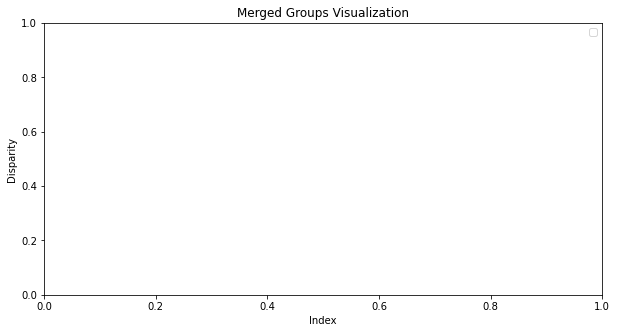

In [161]:
""" 
def merge_lines(index_list, column_data):
    groups = group_indices(index_list)

    print(groups)
    line_params = []
    residuals = []

    # Fit lines and compute residuals for each group
    for group in groups:
        params, res = fit_line_and_residuals(group, column_data)
        line_params.append(params)
        residuals.append(res)

    # Compare each group against each other
    for i in range(len(groups)):
        for j in range(i + 1, len(groups)):
            
            # Combine groups for comparison
            combined_group = groups[i] + groups[j]
            _, combined_res = fit_line_and_residuals(combined_group, column_data)
            kappa = combined_res / (residuals[i] + residuals[j])

            print(kappa)
            
            if kappa < 3:  # Threshold for kappa should be determined empirically
                print(f"Groups {i} and {j} should be merged.")
            else:
                print("No merge")
               

"""
print("Current column index: ",current_column_index)
def merge_lines(index_list, column_data, col_index=current_column_index):
    groups = group_indices(index_list,col_index)
    line_params = []
    residuals = []
    merge_candidates = []

    print("Current column index: ",current_column_index)


    # Fit lines and compute residuals for each group
    for group in groups:
        params, res = fit_line_and_residuals(group, column_data)
        line_params.append(params)
        residuals.append(res)

    # Compare each group against each other
    for i in range(len(groups)):
        for j in range(i + 1, len(groups)):
            # Combine groups for comparison
            combined_group = groups[i] + groups[j]
            _, combined_res = fit_line_and_residuals(combined_group, column_data)
            kappa = combined_res / (residuals[i] + residuals[j])

            print(kappa)

            if kappa < 3:  # Threshold for kappa should be determined empirically
                merge_candidates.append((groups[i], groups[j]))

    return merge_candidates

def plot_merged_groups(merge_candidates, column_data):
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
    plt.figure(figsize=(10, 5))
    
    # Plot all groups with different colors
    for i, groups in enumerate(merge_candidates):
        for group in groups:
            x_vals = group
            y_vals = [column_data[x] for x in group]
            plt.scatter(x_vals, y_vals, color=colors[i % len(colors)], label=f'Group {i+1}', s=10)

    plt.title('Merged Groups Visualization')
    plt.xlabel('Index')
    plt.ylabel('Disparity')
    plt.legend()
    plt.show()


testing_object_list = single_column_list_generator(only_return_hor_col=True)
print("Testing ",testing_object_list)
testing_index_list = generate_index_list(testing_object_list)

print("Testing ",testing_index_list)
testing_column_data = surface_splitting_disparity_image[:, column_index]
testing_y_values = range(len(column_data))

merge_candidates = merge_lines(testing_index_list, testing_column_data)
print("Merge candidates: ", merge_candidates)
plot_merged_groups(merge_candidates, testing_column_data)

#### Slutt testing

In [152]:
"""  
def group_indices(indices, limit=10):
    if not indices:
        return []
    sorted_indices = sorted(indices)
    groups = [[sorted_indices[0]]]
    for index in sorted_indices[1:]:
        if index - groups[-1][-1] <= limit:
            groups[-1].append(index)
        else:
            groups.append([index])
    return groups


"""

'  \ndef group_indices(indices, limit=10):\n    if not indices:\n        return []\n    sorted_indices = sorted(indices)\n    groups = [[sorted_indices[0]]]\n    for index in sorted_indices[1:]:\n        if index - groups[-1][-1] <= limit:\n            groups[-1].append(index)\n        else:\n            groups.append([index])\n    return groups\n\n\n'

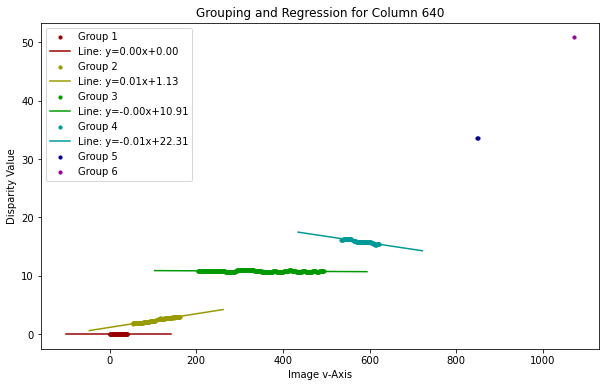

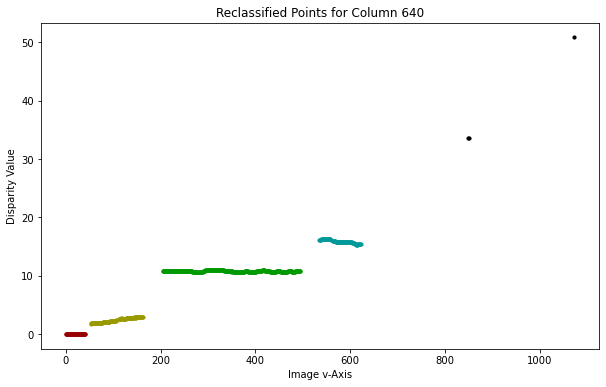

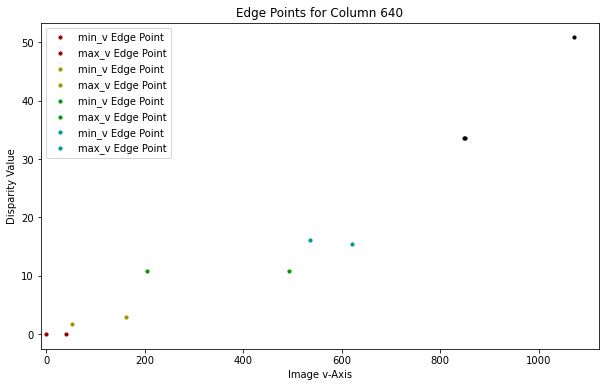

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


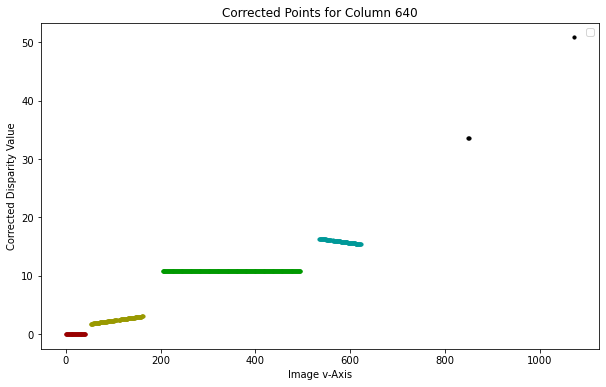

In [153]:
current_column_index = 640  # Example column index
reclassified_points_initial, edge_points_initial, corrected_points, unknown_points =  process_column(current_column_index, plot=True, group_limit=10, label_to_be_used="vertical")

grouped_corrected_points = group_corrected_points_by_line(corrected_points, unknown_points)
newest_test_list, disregarded= new_column_object_list_generator(grouped_corrected_points, label_list=vertical_label_list)

In [154]:
# Takes 15 secs to run
def all_columns_full_object_list_generator(surface_splitting_disparity_image, plot=False, group_limit=10, label_to_be_used="horizontal"):
    if(label_to_be_used == "vertical"):
        label_list=vertical_label_list
        print("Vertical")
    else:
        label_list = horizontal_label_list
        print("Horizontal")
    
    all_columns_full_horizontal_object_list = []
    all_columns_full_object_list = []
    all_corrected_points = []
    column_wise_full_object_list = []
    
    # Assume there is a known number of columns
    total_columns = surface_splitting_disparity_image.shape[1]

    for current_column_index in range(total_columns):
        reclassified_points_initial, edge_points_initial, corrected_points, unknown_points =  process_column(current_column_index, plot=False,group_limit=group_limit, label_to_be_used=label_to_be_used)
        grouped_corrected_points = group_corrected_points_by_line(corrected_points, unknown_points)
        newest_test_list, all_columns_full_object_list = new_column_object_list_generator(grouped_corrected_points, all_columns_full_object_list, label_list=label_list)
        
        
        all_corrected_points.append(corrected_points)
        column_wise_full_object_list.append(newest_test_list)

    return all_columns_full_object_list, all_corrected_points, column_wise_full_object_list

all_columns_full_horizontal_object_list, all_corrected_points_horizontal, column_wise_full_object_list_horizontal = all_columns_full_object_list_generator(surface_splitting_disparity_image, group_limit=20)
all_columns_full_vertical_object_list, all_corrected_points_vertical, column_wise_full_object_list_vertical = all_columns_full_object_list_generator(surface_splitting_disparity_image, group_limit=20, label_to_be_used="vertical")
#print("Length all columns",len(all_columns_full_horizontal_object_list))
#print("Length obj list", len(horizontal_Obj_List))

print("Creating a corrected disparity image:")
corrected_dI = np.copy(dI)

all_corrected_points = all_corrected_points_horizontal
for j in range(corrected_dI.shape[1]):  # Columns
    for index in range(len(all_corrected_points[j])):
        column = j
        row = all_corrected_points[j][index][1]
        corrected_disparity = all_corrected_points[j][index][2]
        #print("Column: ", column)
        #print("Row: ", row)
        #print("Corrected disparity: ",corrected_disparity)
        corrected_dI[row, column] = corrected_disparity

all_corrected_points = all_corrected_points_vertical
for j in range(corrected_dI.shape[1]):  # Columns
    for index in range(len(all_corrected_points[j])):
        column = j
        row = all_corrected_points[j][index][1]
        corrected_disparity = all_corrected_points[j][index][2]
        #print("Column: ", column)
        #print("Row: ", row)
        #print("Corrected disparity: ",corrected_disparity)
        corrected_dI[row, column] = corrected_disparity

all_corrected_points = all_corrected_points_horizontal

print("corrected_dI created")

Horizontal
Vertical
Creating a corrected disparity image:
corrected_dI created


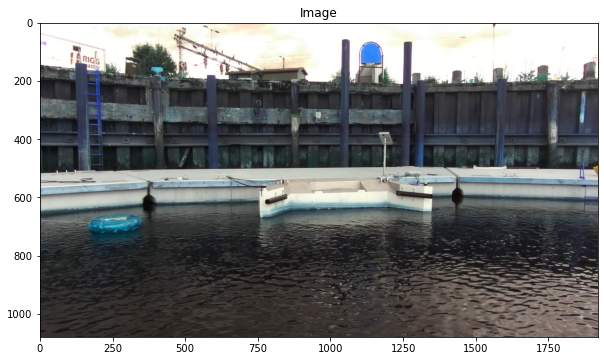

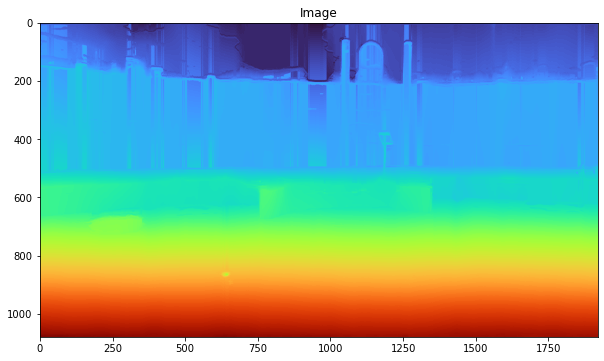

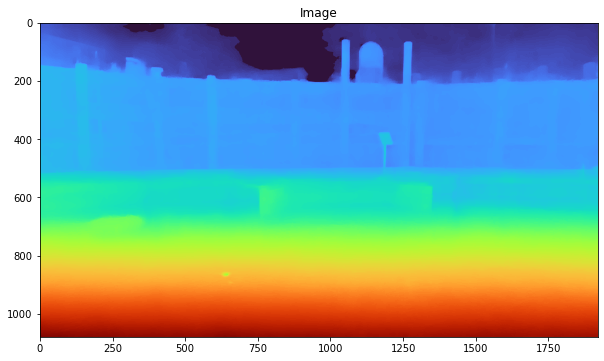

In [155]:
display_disp_image(original_image)
display_disp_image(corrected_dI)
display_disp_image(dI)


In [156]:
print(type(all_corrected_points_horizontal))

<class 'list'>


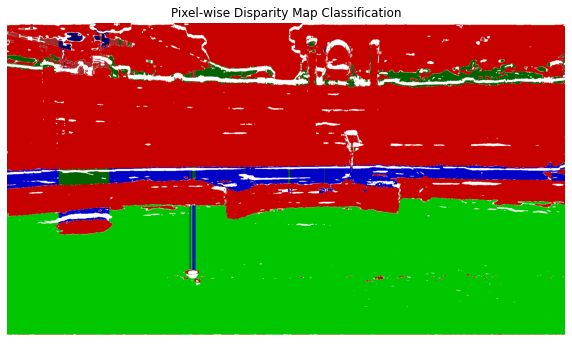

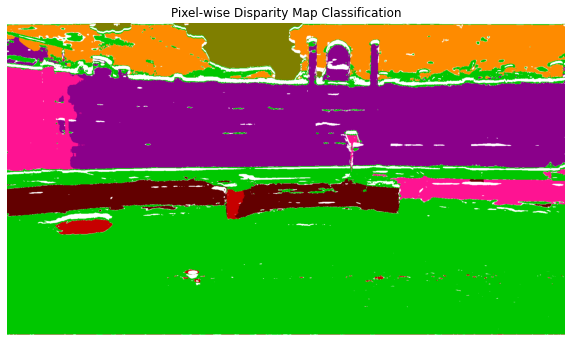

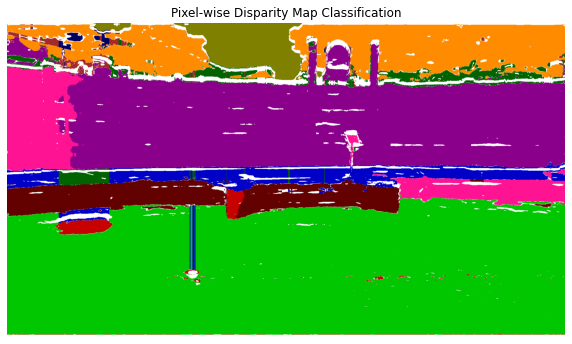

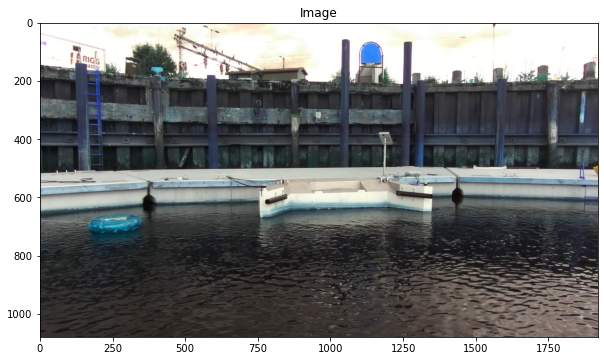

In [157]:
horizontal_test_class_map = np.copy(classification_map)
FULL_TEST_CLASS_MAP = np.copy(new_class_map)


for index, obj in enumerate(all_columns_full_horizontal_object_list):
    i = obj[1]
    j= obj[0]
    lab = obj[3]   
    horizontal_test_class_map[i,j] = obj[3]
    FULL_TEST_CLASS_MAP[i, j] = obj[3]
""" 
# Dark color definitions with brightness < 128/256
Dark_Red = [139/256, 0, 0]  # Rich, dark red
Dark_Blue = [0, 0, 128/256]  # Deep blue, similar to navy
Dark_Green = [0, 100/256, 0]  # Deep green
Bright_Red = [200/256, 0, 0]  # Bright red
Bright_Green = [0, 200/256, 0]  # Bright green
Bright_Blue = [0, 0, 200/256]  # Bright blue
Dark_Yellow = [128/256, 128/256, 0]  # Muted yellow, darkened
Dark_Purple = [75/256, 0, 130/256]  # Similar to indigo, dark purple
Dark_Orange = [255/256, 140/256, 0]  # Vibrant, but darkened to fit within limits
Dark_Cyan = [0, 139/256, 139/256]  # Rich cyan, darkened
Dark_Magenta = [139/256, 0, 139/256]  # Deep magenta
Charcoal_Gray = [50/256, 50/256, 50/256]  # Dark gray, akin to charcoal
Dark_Lime = [50/256, 205/256, 50/256]  # A darker shade of lime green
Dark_Pink = [255/256, 20/256, 147/256]  # Deep pink, darkened
Dark_Olive = [85/256, 107/256, 47/256]  # Muted, darker olive green
Dark_Turquoise = [0, 206/256, 209/256]  # Deep turquoise
Dark_Brown = [165/256, 42/256, 42/256]  # A rich, dark brown
Dark_Goldenrod = [184/256, 134/256, 11/256] # Dark goldenrod
White = [1, 1, 1]  # White

colorScheme = {
    'horizontal1': Bright_Green,
    'horizontal2': Bright_Blue,
    'horizontal3': Dark_Green,
    'horizontal4': Dark_Brown,
    'horizontal5': Dark_Blue,
    'horizontal6': Charcoal_Gray,  # Custom darker teal
    'horizontal7': Dark_Lime,  # Custom dark leaf green
    'vertical1': Bright_Red,
    'vertical2': Dark_Magenta,
    'vertical3': Dark_Yellow,
    'vertical4': Dark_Red,
    'vertical5': Dark_Pink, 
    'vertical6': Dark_Orange,  # Dark Orchid
    'vertical7': Dark_Goldenrod,  # Dark Goldenrod
    'unknown': White,  # White
    'undecided': White,  # White
    'upright': Bright_Red,
    'horizontal': Bright_Green
}
 """



# Create an empty array for the color-coded image
horizontal_color_coded_image = np.zeros((*horizontal_test_class_map.shape, 3))
#print(color_coded_image)
full_color_coded_image = np.zeros((*FULL_TEST_CLASS_MAP.shape, 3))


# Assign colors based on the classification in new_class_map
for label, color in colorScheme.items():
    # Find indices where the current label is present in new_class_map
    indices = np.where(horizontal_test_class_map == label)
    fulldices= np.where(FULL_TEST_CLASS_MAP==label)
    # Assign the corresponding color to these indices in the color-coded image
    horizontal_color_coded_image[indices] = color
    full_color_coded_image[fulldices] = color

#print(color_coded_image)
plt.figure(figsize=(10, 6))
plt.imshow(horizontal_color_coded_image)
plt.title('Pixel-wise Disparity Map Classification')
plt.axis('off')  # Hide the axes
plt.show() 
plt.figure(figsize=(10, 6))
plt.imshow(color_coded_image)
plt.title('Pixel-wise Disparity Map Classification')
plt.axis('off')  # Hide the axes
plt.show() 
plt.figure(figsize=(10, 6))
plt.imshow(full_color_coded_image)
plt.title('Pixel-wise Disparity Map Classification')
plt.axis('off')  # Hide the axes
plt.show() 

display_disp_image(original_image)

In [158]:
# TELEPORTER